# Plotting the results from DeSeq2

## Overview

Here the results from Deseq2 are plotted in the form of clustermaps, taxonomic profiles of most abundant transporters and the log2FoldChange between groups.

In [2]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
sns.set(font_scale=1)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')

## Functionality

In [3]:
def get_representatives(df):
    '''Finds representative families for each transporter based on highest mean'''
    df_mean = df.groupby(["fam","transporter"]).sum().mean(axis=1).reset_index()
    df_mean.sort_values(0,ascending=False,inplace=True)
    df_mean.index = list(range(0,len(df_mean)))
    reps = {}
    for i in df_mean.index:
        fam = df_mean.loc[i,"fam"]
        t = df_mean.loc[i,"transporter"]
        if t in reps.keys():
            continue
        reps[t] = fam
    return reps

In [4]:
def make_groupcols(df,cols,order=False,plot=False):
    group_lut = dict(zip(map(str, order),cols))
    group_colors = pd.Series([df.loc[x,"name"] for x in df.index],index=df.index).map(group_lut)
    group_colors.name = "Sample group"
    if plot: 
        cat_fig,cat_ax = plot_custom_palette(cols,order,"name")
    return group_colors

In [5]:
def row_standardize(df):
    for i in df.index:
        df.loc[i,:] = (df.loc[i,:]-df.loc[i].min()) / df.loc[i].max()
    return df

def row_z_score(df):
    df_z = df.T
    df_z = (df_z-df_z.mean())/df_z.std()
    return df_z.T

In [6]:
def add_xtick_colors(row_axes,groupcols):
    for ax in row_axes:
        label_colors = []
        for tick in ax.get_xticklabels():
            label = tick.get_text()
            try: tick.set_color(groupcols.loc[label])
            except KeyError: tick.set_color("black")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 4})

In [7]:
def annotate_clustermap(ax, dec=1, minval=0.5, col_break=0.9, lowcol="white", medcol="darkgrey", highcol="black"):
    try:
        rows = ax.data.iloc[ax.dendrogram_row.reordered_ind,ax.dendrogram_col.reordered_ind].index
    except AttributeError:
        rows = ax.data.index
    try:
        cols = ax.data.iloc[ax.dendrogram_row.reordered_ind,ax.dendrogram_col.reordered_ind].columns
    except AttributeError:
        cols = ax.data.columns
    # Extract plotted data from ax
    data_norm = ax.data2d
    # Extract original data
    a = ax.data
    if dec == 0:
        a = a.astype(int)
    else:
        a = np.round(a,dec)
    row_labels = [x.get_text() for x in ax.ax_heatmap.yaxis.get_ticklabels()]
    #row_labels.reverse()
    col_labels = [x.get_text() for x in ax.ax_heatmap.xaxis.get_ticklabels()]
    # Iterate each row item
    for row in range(len(a.index)):
        row_label = row_labels[row]
        for col in range(len(a.columns)):
            col_label = col_labels[col]
            zval = data_norm.loc[row_label,col_label]
            val = a.loc[row_label,col_label]
            textcol=lowcol
            if zval == 1.0: 
                textcol = highcol
            elif zval >=col_break:
                textcol = medcol
            if val<=minval: continue
            ax.ax_heatmap.text(col+0.5,row+0.5,val,fontdict={'size':6,'color':textcol, 'horizontalalignment': 'center', 'verticalalignment': 'center'})
    return row_labels, col_labels

In [8]:
def plot_custom_palette(cols,groups,name,axis=None):
    sns.set(font_scale=1)
    df = pd.DataFrame(data=[[1]*len(cols),groups],index=[name,"value"]).T
    fig = plt.figure(figsize=(0.25,2))
    ax = sns.barplot(data=df,x=name,y="value",palette=cols,ax=axis)
    ax.set_xlabel("");
    ax.set_ylabel("");
    ax.patch.set_facecolor("white");
    ax.set_xticklabels("");
    return fig,ax

In [9]:
def get_ntaxa(df,n=50):
    taxa = []
    for sample in df.columns:
        sample_sum =0
        df_sample_sort = df.sort_values(sample,ascending=False)
        for tax in df_sample_sort.index:
            sample_sum+=df_sample_sort.loc[tax,sample]
            taxa.append(tax)
            if sample_sum>=n: break
    taxa_sort = df.loc[set(taxa)].mean(axis=1).sort_values(ascending=False).index
    return taxa_sort

In [10]:
def get_quantile_transporters(df,q=0.5):
    '''Pair-wise sample differences are calculated for each transporter and transporters
    that have a maximum absolute difference above the 50% quantile across samples are kept'''
    data = df.groupby(level=0).sum()
    q_trans = []
    for sample in data.columns:
        sample_diff = abs(data.subtract(data[sample],axis=0))
        sample_diff_max = sample_diff.max(axis=1).sort_values(ascending=False)
        sample_diff_max_q = sample_diff_max.quantile(q=q)
        q_trans += list(sample_diff_max[sample_diff_max>=sample_diff_max_q].index)
    return list(set(q_trans))

## Load the data

### Load environmental data

In [11]:
env = pd.read_csv("data/LMO.time.series.metadata.csv", header=0, sep="\t", index_col=0)
env.rename(index = lambda x: str(x), inplace=True)

### Load the transporter data

This has been processed using the [01.process_data](01.process_data.ipynb) notebook.

In [12]:
mg_select_transcov_genes = pd.read_csv("results/mg/select_trans_genes.tpm.tsv", index_col=0, sep="\t", header=0)
mg_select_transcov = pd.read_csv("results/mg/select_trans.tpm.tsv", index_col=0, sep="\t", header=0)

mg_bac_select_transcov_genes = pd.read_csv("results/mg/bac_select_trans_genes.tpm.tsv", index_col=0, sep="\t", header=0)
mg_bac_select_transcov = pd.read_csv("results/mg/bac_select_trans.tpm.tsv", index_col=0, sep="\t", header=0)

In [13]:
mt_select_transcov_genes = pd.read_csv("results/mt/select_trans_genes.tpm.tsv", index_col=0, sep="\t", header=0)
mt_select_transcov = pd.read_csv("results/mt/select_trans.tpm.tsv", index_col=0, sep="\t", header=0)

mt_bac_select_transcov_genes = pd.read_csv("results/mt/bac_select_trans_genes.tpm.tsv", index_col=0, sep="\t", header=0)
mt_bac_select_transcov = pd.read_csv("results/mt/bac_select_trans.tpm.tsv", index_col=0, sep="\t", header=0)

### Load results from DESeq2

These results were obtained by running Deseq2 with the [05.process_and_run_deseq2.ipynb](05.process_and_run_deseq2.ipynb) notebook.

In [14]:
mg_deseq = pd.read_csv("results/mg/deseq2.tab", header=0, sep="\t", index_col=7)
mt_deseq = pd.read_csv("results/mt/deseq2.tab", header=0, sep="\t", index_col=7)

In [15]:
# Get representative TIGRFAMs for use with y-axis
trans_reps = get_representatives(mg_select_transcov_genes)

### Read sample groupings

Sample groups were identified with the [02.cluster_samples.ipynb](02.cluster_samples.ipynb) notebook.

In [16]:
mg_groups = pd.read_csv("results/mg/samplegroups.tab", header=0, sep="\t", index_col=0)
mg_groups.rename(index=lambda x: str(x), inplace=True)
mt_groups = pd.read_csv("results/mt/samplegroups.tab", header=0, sep="\t", index_col=0)
mt_groups.rename(index=lambda x: str(x), inplace=True)

### Read selected transporters

In [17]:
transinfo = pd.read_csv("selected_transporters_classified.tab", sep="\t", header=0)

In [18]:
cats = ["Anions","Cations","Nitrate","Metal","Urea","Phosphate","Phosphonate","AA peptide + (NH4+)","Nucleoside","Carbohydrate"]

## Plots

### Plot group legend

In [19]:
mg_palette = sns.color_palette("YlGn",n_colors=2)+sns.color_palette("YlOrBr",n_colors=3)+sns.color_palette("PuBu",n_colors=1)

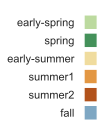

In [24]:
mg_groupcols = make_groupcols(mg_groups,mg_palette,order=["early-spring","spring","early-summer","summer1","summer2","fall"],plot=True)
plt.savefig("NEW_figures_2020/MG_grouplegend.eps",bbox_inches="tight")

In [21]:
mt_palette = [sns.color_palette("YlGn",n_colors=2)[1]]+[sns.color_palette("YlOrBr",n_colors=2)[1]]+sns.color_palette("PuBu",n_colors=2)

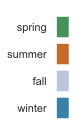

In [22]:
mt_groupcols = make_groupcols(mt_groups,mt_palette,order=["spring","summer","fall","winter"],plot=True)
plt.savefig("results/MT_grouplegend.svg",bbox_inches="tight")

### Plot category legend

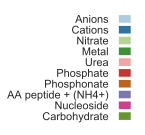

In [23]:
cat_cols = sns.color_palette("Paired", 6) + sns.color_palette("Dark2",5)[1:]
cat_lut = dict(zip(map(str,cats),cat_cols))
cat_lut["Other"] = "black"
cat_lut["Rare nutr"] = "grey"
plot_custom_palette(cat_cols,cats,name="Category");
plt.savefig("NEW_figures_2020/Substrate_category_legend.eps", bbox_inches="tight")


### Plot clustermaps

#### Metagenomes

In [23]:
# Order samples by their sample group
mg_sample_order = []
for g in "early-spring","spring","early-summer","summer1","summer2","fall":
    for s in mg_groups.loc[mg_groups["name"]==g].index: mg_sample_order.append(s)

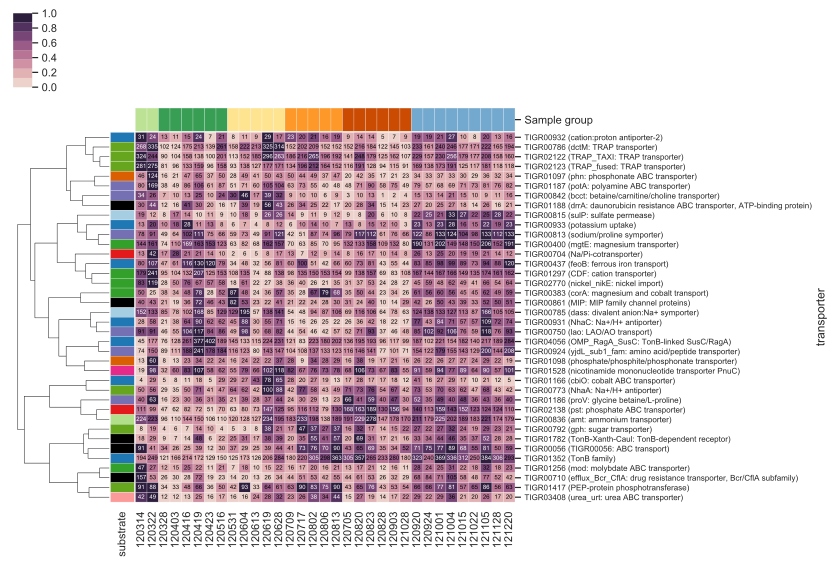

In [24]:
# Get transporters with an adjusted p-value < 0.05 in at least one of the Dseq2 comparisons
trans = set(mg_deseq.loc[mg_deseq.p_total_adj<0.05].index)
# Generate the data for plotting
clust_data = mg_select_transcov.loc[trans][mg_groups.index]
clust_data = clust_data[mg_sample_order]
clust_data_original = clust_data.copy(deep=True)
# Cluster transporters
row_linkage = linkage(pdist(clust_data, metric="correlation"), metric="correlation", method="complete")

# Annotate rows with the category legend colors
row_cols = pd.Series([mg_select_transcov.loc[t,"substrate_category"] for t in trans],index=trans).map(cat_lut)
row_cols.name="substrate"

# Plot the clustermap
mg_ax = sns.clustermap(clust_data,method="complete",metric="correlation",standard_scale=0, col_cluster=False, row_cluster=True, cmap=sns.cubehelix_palette(8),
                       col_colors=mg_groupcols, row_colors=row_cols, yticklabels=True,
                       figsize=(9,9),linewidths=0.2)
# Rotate the transporter labels
plt.setp(mg_ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
# Annotate the clustermap to add the TPM values to cells
row_labels, col_labels = annotate_clustermap(ax=mg_ax, dec=0, col_break=0.7, lowcol="black", highcol="white", medcol="white")
# Change transporter labels to include the second category substrate
ticklocs = []
ticklabels = []
for i,item in enumerate(row_labels):
    ticklocs.append(i+0.5)
    fam = trans_reps[item]
    fam_name = mg_select_transcov_genes.loc[mg_select_transcov_genes.fam==fam,"name"].unique()[0]
    ticklabels.append("{} ({})".format(fam,fam_name))
mg_ax.ax_heatmap.yaxis.set_ticks(ticklocs)
mg_ax.ax_heatmap.yaxis.set_ticklabels(ticklabels,fontsize=8);
plt.savefig("NEW_figures_2020/Figure_6.eps", bbox_inches="tight")

#### Metatranscriptomes

In [25]:
mt_sample_order = []
for g in "spring","summer","fall","winter":
    for s in mt_groups.loc[mt_groups["name"]==g].index: mt_sample_order.append(s)

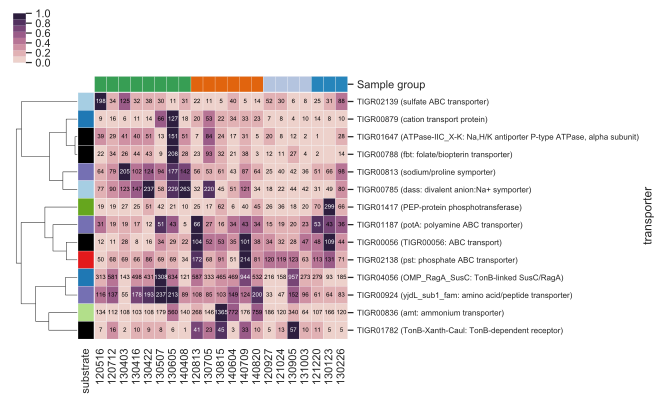

In [26]:
# Get transporters with an adjusted p-value < 0.05 in at least one of the Dseq2 comparisons
trans = set(mt_deseq.loc[mt_deseq.p_total_adj<0.05].index)
# Generate the data for plotting
clust_data = mt_select_transcov.loc[trans][mt_groups.index]
clust_data = clust_data[mt_sample_order]
clust_data_original = clust_data.copy(deep=True)
# Cluster transporters
row_linkage = linkage(pdist(clust_data, metric="correlation"), metric="correlation", method="complete")

# Annotate rows with the category legend colors
row_cols = pd.Series([mt_select_transcov.loc[t,"substrate_category"] for t in trans],index=trans).map(cat_lut)
row_cols.name="substrate"

# Plot the clustermap
mt_ax = sns.clustermap(clust_data,method="complete",metric="correlation",standard_scale=0, col_cluster=False, row_cluster=True, cmap=sns.cubehelix_palette(8),
                       col_colors=mt_groupcols, row_colors=row_cols, yticklabels=True,
                       figsize=(6,6),linewidths=0.2)
# Rotate the transporter labels
plt.setp(mt_ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
# Annotate the clustermap to add the TPM values to cells
row_labels, col_labels = annotate_clustermap(ax=mt_ax, dec=0, col_break=0.7, lowcol="black", highcol="white", medcol="white")
# Change transporter labels to include the second category substrate
ticklocs = []
ticklabels = []
for i,item in enumerate(row_labels):
    ticklocs.append(i+0.5)
    fam = trans_reps[item]
    fam_name = mg_select_transcov_genes.loc[mg_select_transcov_genes.fam==fam,"name"].unique()[0]
    ticklabels.append("{} ({})".format(fam,fam_name))
mt_ax.ax_heatmap.yaxis.set_ticks(ticklocs)
mt_ax.ax_heatmap.yaxis.set_ticklabels(ticklabels,fontsize=8);

Extract subsets of transporters with similar abundance profiles and plot their taxonomic distribution

### Plot deseq2 log fold change

In [27]:
def process_deseq_for_plotting(df,transinfo):
    df_sig = df.loc[df.p_total_adj<0.05]
    df_sig_info = pd.merge(transinfo,df_sig,left_on="transporter",right_index=True)
    #df_sig_info["transporter"] = df_sig_info.index
    return df_sig_info

Here we plot the log2 fold change for transporters that differ significantly in abundance between the sample groups.

In [28]:
mg_select_transcov = pd.read_table("results/mg/select_trans.tpm.tsv")
mg_deseq = pd.read_table("results/mg/deseq2.tab", index_col=7)
mg_deseq_info = pd.merge(transinfo,mg_deseq,left_on="transporter",right_index=True)
mg_deseq_sig_info = process_deseq_for_plotting(mg_deseq,transinfo)
mt_select_transcov = pd.read_table("results/mt/select_trans.tpm.tsv")
mt_deseq = pd.read_table("results/mt/deseq2.tab", index_col=7)
mt_deseq_info = pd.merge(transinfo,mt_deseq,left_on="transporter",right_index=True)
mt_deseq_sig_info = process_deseq_for_plotting(mt_deseq,transinfo)

Read the DEseq2 results generated by [05.process_and_run_deseq2.ipynb](05.process_and_run_deseq2.ipynb).

In [29]:
def get_bar_colors(rc):
    bar_colors = {}
    for t in rc.index:
        category = transinfo.loc[transinfo.transporter==t,"substrate_category"].values[0]
        bar_colors[t] = cat_lut[category]
    return bar_colors

In [30]:
def plot_substrate_bar(df, group, axis):
    # Get all comparisons where a transporter has a higher log2FoldChange in the group
    _df_up1 = df.loc[(df.groups.str.contains("{} vs ".format(group)))&(df.log2FoldChange>0)&(df.substrate_category.isin(cats))]
    # Get all comparisons where a transporter has a lower log2FoldChange in another group
    _df_up2 = df.loc[(df.groups.str.contains(" vs {}".format(group)))&(df.log2FoldChange<0)&(df.substrate_category.isin(cats))]
    # Concatenate the two dataframes
    _df_up = pd.concat([_df_up1,_df_up2])
    # Select only the first of each unique transporter, groupby substrate category and count
    _df_up = _df_up.groupby("transporter").first().groupby("substrate_category").count().iloc[:,0]

    # Do the same as above but for 'down-regulated' transporters
    _df_down1 = df.loc[(df.groups.str.contains("{} vs ".format(group)))&(df.log2FoldChange<0)&(df.substrate_category.isin(cats))]
    _df_down2 = df.loc[(df.groups.str.contains(" vs {}".format(group)))&(df.log2FoldChange>0)&(df.substrate_category.isin(cats))]
    _df_down = pd.concat([_df_down1,_df_down2])
    _df_down = _df_down.groupby("transporter").first().groupby("substrate_category").count().iloc[:,0]
    _df = pd.concat([_df_down,_df_up],axis=1)
    _df.columns = ["-","+"]
    ax = _df.T.plot(kind="bar", stacked=True, color=[cat_lut[x] for x in _df.index], ax=axis, legend=None)
    return ax

#### Plot pairwise seasonal comparison of groups

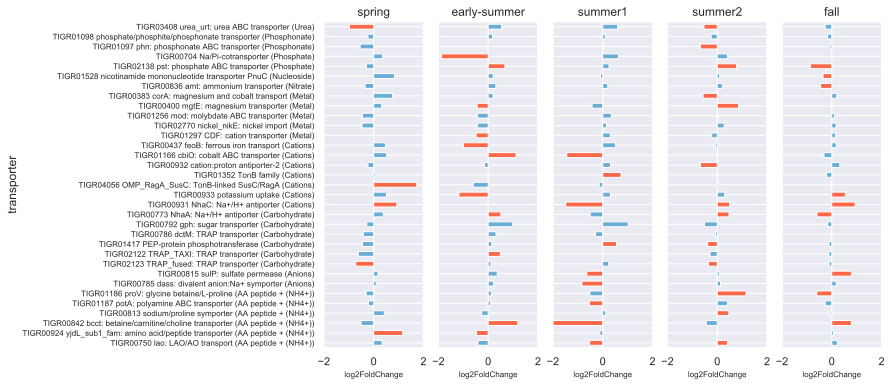

In [31]:
# Sort by substrate category
substrate_cats = ["Anions","Cations","Nitrate","Metal","Urea","Phosphate","Phosphonate","AA peptide + (NH4+)","Nucleoside","Carbohydrate"]
mg_deseq_info.sort_values("substrate_category",inplace=True)
mg_deseq_sig_info.sort_values("substrate_category", inplace=True)
# Get list of significant transporters (these are all that will be plotted)
mg_deseq_sig_info_transporters = mg_deseq_sig_info.loc[mg_deseq_sig_info.substrate_category.isin(substrate_cats)].transporter.unique()
groups = ["early-spring","spring","early-summer","summer1","summer2","fall"]
# Set up figure
fig, axes = plt.subplots(ncols=len(groups)-1, nrows=1, sharex=True, sharey=False, figsize=(10,6))
j = 0
for i, g in enumerate(groups):
    if i==0:
        continue
    # Figure out which groups are being compared and whether to reverse the log2foldchange or not
    compare_group = groups[i-1]
    deseq_group = "{} vs {}".format(g, compare_group)
    deseq_group_r = "{} vs {}".format(compare_group, g)
    if deseq_group in mg_deseq_info.groups.unique():
        group_string = deseq_group
        reverse = False
    else:
        group_string = deseq_group_r
        reverse = True
    # Get transporter results for the groups  
    _df = mg_deseq_info.loc[mg_deseq_info.groups==group_string]
    # Get significant transporters
    sig_trans = _df.loc[_df.p_total_adj<0.05,"transporter"]
    _df.set_index("transporter",inplace=True)
    
    
    _df = _df.loc[mg_deseq_sig_info_transporters,"log2FoldChange"]
    # Set colors to blue (non-significant) or red (significant)
    colors = []
    for trans in _df.index:
        if trans in list(sig_trans):
            colors.append(sns.color_palette("Reds",1)[0])
        else:
            colors.append(sns.color_palette("Blues",1)[0])
    if reverse:
        _df = _df.multiply(-1)
    ax = _df.plot(kind="barh", ax=axes[j], color=colors)
    ax.set_xlim(-2,2)
    ax.set_title(g)
    if i>1:
        axes[j].set_ylabel("")
        axes[j].set_yticklabels("")
    else:
        ylabels = []
        for label in ax.get_yticklabels():
            transporter = label.get_text()
            fam = trans_reps[transporter]
            cat = transinfo.loc[transinfo.transporter==transporter,"substrate_category"].values[0]
            name = fam_name = mg_select_transcov_genes.loc[mg_select_transcov_genes.fam==fam,"name"].unique()[0]
            ylabels.append("{f} {n} ({c})".format(f=fam, n=name, c=cat))
        ax.set_yticklabels(ylabels, fontsize=8)
    axes[j].set_xlabel("log2FoldChange", fontsize=8)
    j+=1
plt.subplots_adjust(wspace=0.15)

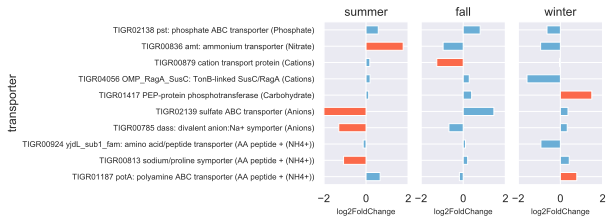

In [32]:
# Sort by substrate category
mt_deseq_info.sort_values("substrate_category",inplace=True)
mt_deseq_sig_info.sort_values("substrate_category", inplace=True)
# Get list of significant transporters (these are all that will be plotted)
mt_deseq_sig_info_transporters = mt_deseq_sig_info.loc[mt_deseq_sig_info.substrate_category.isin(substrate_cats)].transporter.unique()
groups = ["spring","summer","fall","winter"]
# Set up figure
fig, axes = plt.subplots(ncols=len(groups)-1, nrows=1, sharex=True, sharey=False, figsize=(5,3))
j = 0
for i, g in enumerate(groups):
    if i==0:
        continue
    # Figure out which groups are being compared and whether to reverse the log2foldchange or not
    compare_group = groups[i-1]
    deseq_group = "{} vs {}".format(g, compare_group)
    deseq_group_r = "{} vs {}".format(compare_group, g)
    if deseq_group in mt_deseq_info.groups.unique():
        group_string = deseq_group
        reverse = False
    else:
        group_string = deseq_group_r
        reverse = True
    # Get transporter results for the groups  
    _df = mt_deseq_info.loc[mt_deseq_info.groups==group_string]
    # Get significant transporters
    sig_trans = _df.loc[_df.p_total_adj<0.05,"transporter"]
    _df.set_index("transporter",inplace=True)
    
    
    _df = _df.loc[mt_deseq_sig_info_transporters,"log2FoldChange"]
    # Set colors to blue (non-significant) or red (significant)
    colors = []
    for trans in _df.index:
        if trans in list(sig_trans):
            colors.append(sns.color_palette("Reds",1)[0])
        else:
            colors.append(sns.color_palette("Blues",1)[0])
    if reverse:
        _df = _df.multiply(-1)
    ax = _df.plot(kind="barh", ax=axes[j], color=colors)
    ax.set_xlim(-2,2)
    ax.set_title(g)
    if i>1:
        axes[j].set_ylabel("")
        axes[j].set_yticklabels("")
    else:
        ylabels = []
        for label in ax.get_yticklabels():
            transporter = label.get_text()
            fam = trans_reps[transporter]
            cat = transinfo.loc[transinfo.transporter==transporter,"substrate_category"].values[0]
            name = mg_select_transcov_genes.loc[mg_select_transcov_genes.fam==fam,"name"].unique()[0]
            ylabels.append("{f} {n} ({c})".format(f=fam, n=name, c=cat))
        ax.set_yticklabels(ylabels, fontsize=8)
    axes[j].set_xlabel("log2FoldChange", fontsize=8)
    j+=1
plt.subplots_adjust(wspace=0.15)